# <font color='red'> Business Objective/Problem </font>
+ Tiki là một hệ sinh thái thương mại “all in one”, trong 
đó có tiki.vn, là một website thương mại điện tử đứng 
top 2 của Việt Nam, top 6 khu vực Đông Nam Á.
+ Trên trang này đã triển khai nhiều tiện ích hỗ trợ nâng 
cao trải nghiệm người dùng và họ muốn xây dựng 
nhiều tiện ích hơn nữa.
+ Giả sử công ty này chưa triển khai Recommender 
System và bạn được yêu cầu triển khai hệ thống này, 
bạn sẽ làm gì?

# <font color='blue'> Các kiến thức/ kỹ năng cần để giải quyết vấn đề này: </font>
+ Hiểu vấn đề
+ Import các thư viện cần thiết và hiểu cách sử dụng
+ Đọc dữ liệu (dữ liệu project này được cung cấp)
+ Thực hiện EDA cơ bản (sử dụng Pandas Profiling 
Report)
+ Tiền xử lý dữ liệu: làm sạch, tạo tính năng mới, lựa 
chọn tính năng cần thiết…
+ Trực quan hóa dữ liệu
+ Lựa chọn thuật toán cho bài toán 
recommendation system
+ Xây dựng model
+ Đánh giá model 
+ Báo cáo kết quả


# <font color='blue'> Triển khai dự án </font>
**Bước 1: Business Understanding**
+ Dựa vào yêu cầu nói trên => xác định vấn đề: 
> + Chưa có hệ thống Recommendation System 
> + => Mục tiêu/ vấn đề: Xây dựng Recommendation System 
cho một hoặc một số nhóm hàng hóa trên tiki.vn giúp đề 
xuất và gợi ý cho người dùng/ khách hàng. => Xây dựng 
các mô hình đề xuất:
> > + Content-based filtering
> > + Collaborative filtering


**Bước 2: Data Understanding/ Acquire**
+ Từ mục tiêu/ vấn đề đã xác định: xem xét các dữ 
liệu cần thiết:
> + Dữ liệu được cung cấp sẵn gồm có các tập tin: 
ProductRaw.csv, ReviewRaw.csv chứa thông tin sản phẩm, 
review và rating cho các sản phẩm thuộc các nhóm hàng 
hóa như Mobile_Tablet, TV_Audio, Laptop, Camera, 
Accessory.

In [ ]:
#@title Install Packages
!pip install gensim
!pip install underthesea
!pip install jieba
!pip install import_ipynb

     |████████████████████████████████| 7.5 MB 5.0 MB/s 
     |████████████████████████████████| 3.4 MB 47.1 MB/s 
     |████████████████████████████████| 235 kB 52.8 MB/s 
     |████████████████████████████████| 743 kB 31.0 MB/s 
     |████████████████████████████████| 43 kB 1.6 MB/s 
     |████████████████████████████████| 596 kB 15.5 MB/s 
     |████████████████████████████████| 3.3 MB 42.8 MB/s 
     |████████████████████████████████| 61 kB 437 kB/s 
     |████████████████████████████████| 895 kB 44.3 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16181 sha256=478f02071a3cac026ddbff10ee442f9d70fa58870f8a0ab2e22c94307ab6e6bd
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Created wheel for import-ipynb: filename=impor

In [ ]:
#@title Import Pakages
import os
import json
import re
import numpy as np
import pandas as pd
import seaborn as sns
import difflib
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from underthesea import word_tokenize, pos_tag, sent_tokenize
from gensim import corpora, models, similarities
import jieba
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [ ]:
%cd '/content/gdrive/MyDrive/LDS0_k271_NgoThiNga/Project 3'

/content/gdrive/MyDrive/LDS0_k271_NgoThiNga/Project 3


In [ ]:
#@title Import define function
import import_ipynb
from my_lib import *

importing Jupyter notebook from my_lib.ipynb


In [ ]:
products = pd.read_csv('dataset/Product.csv', index_col=0)
products.head(3)

,item_id,name,description,rating,price,list_price,brand,group,url,image
0,48102821,Tai nghe Bluetooth Inpods 12 - Cảm biến vân ta...,THÔNG TIN CHI TIẾT\nDung lượng pin 300\nThời g...,4.0,77000,300000,OEM,Thiết Bị Số - Phụ Kiện Số/Thiết Bị Âm Thanh và...,https://tai-nghe-bluetooth-inpods-12-cam-bien-...,https://salt.tikicdn.com/cache/280x280/ts/prod...
1,52333193,Tai nghe bluetooth không dây F9 True wireless ...,THÔNG TIN CHI TIẾT\nDung lượng pin 2000mah\nTh...,4.5,132000,750000,OEM,Thiết Bị Số - Phụ Kiện Số/Thiết Bị Âm Thanh và...,https://tai-nghe-bluetooth-khong-day-f9-true-w...,https://salt.tikicdn.com/cache/280x280/ts/prod...
2,299461,Chuột Không Dây Logitech M331 Silent - Hàng Ch...,THÔNG TIN CHI TIẾT\nThương hiệu Logitech\nĐộ p...,4.8,299000,399000,Logitech,Thiết Bị Số - Phụ Kiện Số/Phụ kiện máy tính và...,https://chuot-khong-day-logitech-m331-silent-p...,https://salt.tikicdn.com/cache/280x280/media/c...


In [ ]:
df = products.copy(deep=True)
df.shape

(4370, 10)

In [ ]:
# read Vietnamese stopwords file
STOP_WORD_FILE = 'dataset/vietnamese-stopwords.txt'
with open(STOP_WORD_FILE, 'r', encoding='utf-8') as file:
  stop_words = file.read()

stop_words = stop_words.split('\n')

In [ ]:
# Tạo thuộc tính content là sự kết hợp của các thuộc tính name và description
df['product'] = df['name'] + df['description']
df = df.reset_index()
df.head(3)

,index,item_id,name,description,rating,price,list_price,brand,group,url,image,product
0,0,48102821,Tai nghe Bluetooth Inpods 12 - Cảm biến vân ta...,THÔNG TIN CHI TIẾT\nDung lượng pin 300\nThời g...,4.0,77000,300000,OEM,Thiết Bị Số - Phụ Kiện Số/Thiết Bị Âm Thanh và...,https://tai-nghe-bluetooth-inpods-12-cam-bien-...,https://salt.tikicdn.com/cache/280x280/ts/prod...,Tai nghe Bluetooth Inpods 12 - Cảm biến vân ta...
1,1,52333193,Tai nghe bluetooth không dây F9 True wireless ...,THÔNG TIN CHI TIẾT\nDung lượng pin 2000mah\nTh...,4.5,132000,750000,OEM,Thiết Bị Số - Phụ Kiện Số/Thiết Bị Âm Thanh và...,https://tai-nghe-bluetooth-khong-day-f9-true-w...,https://salt.tikicdn.com/cache/280x280/ts/prod...,Tai nghe bluetooth không dây F9 True wireless ...
2,2,299461,Chuột Không Dây Logitech M331 Silent - Hàng Ch...,THÔNG TIN CHI TIẾT\nThương hiệu Logitech\nĐộ p...,4.8,299000,399000,Logitech,Thiết Bị Số - Phụ Kiện Số/Phụ kiện máy tính và...,https://chuot-khong-day-logitech-m331-silent-p...,https://salt.tikicdn.com/cache/280x280/media/c...,Chuột Không Dây Logitech M331 Silent - Hàng Ch...


In [ ]:
df['product_wt'] = df['product'].apply(lambda x: word_tokenize(x,format='text'))
df = df[['index','item_id','name','description','product_wt', 'url', 'image', 'rating','price','brand']]
df.head(3)

,index,item_id,name,description,product_wt,url,image,rating,price,brand
0,0,48102821,Tai nghe Bluetooth Inpods 12 - Cảm biến vân ta...,THÔNG TIN CHI TIẾT\nDung lượng pin 300\nThời g...,Tai_nghe Bluetooth_Inpods 12 - Cảm_biến vân ta...,https://tai-nghe-bluetooth-inpods-12-cam-bien-...,https://salt.tikicdn.com/cache/280x280/ts/prod...,4.0,77000,OEM
1,1,52333193,Tai nghe bluetooth không dây F9 True wireless ...,THÔNG TIN CHI TIẾT\nDung lượng pin 2000mah\nTh...,Tai_nghe bluetooth không dây F9_True wireless ...,https://tai-nghe-bluetooth-khong-day-f9-true-w...,https://salt.tikicdn.com/cache/280x280/ts/prod...,4.5,132000,OEM
2,2,299461,Chuột Không Dây Logitech M331 Silent - Hàng Ch...,THÔNG TIN CHI TIẾT\nThương hiệu Logitech\nĐộ p...,Chuột Không Dây Logitech_M331_Silent - Hàng Ch...,https://chuot-khong-day-logitech-m331-silent-p...,https://salt.tikicdn.com/cache/280x280/media/c...,4.8,299000,Logitech


In [ ]:
# save data after work-tokenizer
df.to_csv('/content/gdrive/MyDrive/LDS0_k271_NgoThiNga/Project 3/dataset/Product_wt.csv')

# 1. Gensim

In [ ]:
# Tokenize(spli) the sentences into words
products_gem = [[text for text in x.split()] for x in df.product_wt]

In [ ]:
products_gem[:1]

[['Tai_nghe',
  'Bluetooth_Inpods',
  '12',
  '-',
  'Cảm_biến',
  'vân',
  'tay',
  ',',
  'chống',
  'nước',
  ',',
  'màu_sắc',
  'đa_dạng',
  '-',
  '5',
  'màu_sắc',
  'lựa',
  'chọnTHÔNG',
  'TIN',
  'CHI_TIẾT',
  'Dung_lượng',
  'pin',
  '300',
  'Thời_gian',
  'pin',
  '-',
  'Thời_gian',
  'nghe',
  'nhạc',
  'liên_tục',
  'từ',
  '2.5',
  '-',
  '4',
  'h',
  '-',
  'Thời_gian',
  'sạc',
  'đầy',
  'chỉ',
  'khoảng',
  '60',
  'p',
  '-',
  'Thời_gian',
  'chờ',
  'lên',
  'tới',
  '140',
  'giờ',
  'Bluetooth',
  '5',
  'Thương_hiệu',
  'OEM',
  'Xuất_xứ',
  'thương_hiệu',
  'Trung_Quốc',
  'Độ',
  'nhạy_cảm_biến',
  'vân',
  'tay',
  'Model',
  'i12',
  'Loại',
  'Jack',
  'cắm',
  'USB_Cable',
  'Trọng_lượng',
  '300',
  'g',
  'Thời_gian',
  'sử_dụng',
  '-',
  'Thời_gian',
  'nghe',
  'nhạc',
  'liên_tục',
  'từ',
  '2.5',
  '-',
  '4',
  'h',
  'SKU',
  '4096608751631',
  'MÔ_TẢ',
  'SẢN_PHẨM',
  'INPOD',
  '12',
  'là',
  'phiên_bản',
  'nâng_cấp',
  'mới',
  'nhất',
 

In [ ]:
import re
# remove some special elements in texts
pattern = r'[0-9]+|\–|\+|\:|\(|\)|\"|\%|\$|\&|\#|\@|\!|\*|\^|\;|\[|\]|\=|\{|\}|\.|\,|\'|\-|\|\<|\>|\xa0|\n|\…|\≥|\•|\//|\±|\”|\“'
# products_gem_re = [[re.sub('[0-9]+','', e) for e in text] for text in products_gem] # số
products_gem_re = [[re.sub(pattern,'', e) for e in text] for text in products_gem] # ký tự đặc biệt
products_gem_re = [[t.lower() for t in text if not t in ['', ' ', ',', '.', '...', '-',':', ';', '?', '%', '(', ')', '+', '/']] for text in  products_gem_re] 
products_gem_re = [[t for t in text if not t in stop_words] for text in products_gem_re] # stopword


In [ ]:
products_gem_re[:1]

[['tai_nghe',
  'bluetooth_inpods',
  'cảm_biến',
  'vân',
  'chống',
  'màu_sắc',
  'đa_dạng',
  'màu_sắc',
  'lựa',
  'chọnthông',
  'chi_tiết',
  'dung_lượng',
  'pin',
  'pin',
  'nhạc',
  'liên_tục',
  'h',
  'sạc',
  'p',
  'chờ',
  'bluetooth',
  'thương_hiệu',
  'oem',
  'xuất_xứ',
  'thương_hiệu',
  'trung_quốc',
  'độ',
  'nhạy_cảm_biến',
  'vân',
  'model',
  'jack',
  'cắm',
  'usb_cable',
  'trọng_lượng',
  'g',
  'nhạc',
  'liên_tục',
  'h',
  'sku',
  'mô_tả',
  'sản_phẩm',
  'inpod',
  'phiên_bản',
  'nâng_cấp',
  'tai_nghe',
  'bluetooth',
  'thiết_kế',
  'tỉ_lệ',
  'chuẩn',
  'tai',
  'airpod',
  'hãng',
  'lược_bỏ',
  'nút',
  'bấm',
  'thân',
  'tai',
  'thay',
  'nút',
  'cảm_ứng',
  'dễ_dàng',
  'thuận_tiện',
  'thao_tác',
  'nhạc',
  'dễ_dàng',
  'chạm',
  'bluetooth',
  'kết_nối',
  'vô_cùng',
  'ổn_định',
  'bluetooth',
  'kết_nối',
  'vô_cùng',
  'ổn_định',
  'tai',
  'kết_nối',
  'dock',
  'sạc',
  'chất',
  'âm',
  'thời_lượng',
  'pin',
  'cải_thiện',
  'tố

In [ ]:
# Obtain number of features based on dictionary:  Use corpora.Dictionay
dictionary = corpora.Dictionary(products_gem_re)

In [ ]:
# List of features in dictionary
dictionary.token2id

{'airpod': 0,
 'apple': 1,
 'bao_gồm': 2,
 'bluetooth': 3,
 'bluetooth_inpods': 4,
 'bấm': 5,
 'chi_phí': 6,
 'chi_tiết': 7,
 'chuẩn': 8,
 'chạm': 9,
 'chất': 10,
 'chọnthông': 11,
 'chống': 12,
 'chờ': 13,
 'cải_thiện': 14,
 'cảm_biến': 15,
 'cảm_ứng': 16,
 'cắm': 17,
 'cồng_kềnh': 18,
 'dock': 19,
 'dung_lượng': 20,
 'dễ_dàng': 21,
 'g': 22,
 'giao': 23,
 'giá': 24,
 'h': 25,
 'hiện_hành': 26,
 'huawei': 27,
 'hàng': 28,
 'hãng': 29,
 'inpod': 30,
 'jack': 31,
 'kết_nối': 32,
 'lenovo': 33,
 'liên_tục': 34,
 'luật': 35,
 'lược_bỏ': 36,
 'lựa': 37,
 'model': 38,
 'màu_sắc': 39,
 'mô_tả': 40,
 'nhạc': 41,
 'nhạy_cảm_biến': 42,
 'nâng_cấp': 43,
 'nút': 44,
 'oem': 45,
 'oppo': 46,
 'p': 47,
 'phiên_bản': 48,
 'phát_sinh': 49,
 'phí': 50,
 'phương_thức': 51,
 'phụ_phí': 52,
 'pin': 53,
 'samsung': 54,
 'sku': 55,
 'sạc': 56,
 'sản_phẩm': 57,
 'tablet': 58,
 'tai': 59,
 'tai_nghe': 60,
 'thao_tác': 61,
 'thay': 62,
 'thiết_bị': 63,
 'thiết_kế': 64,
 'thuận_tiện': 65,
 'thuế': 66,
 'thân':

In [ ]:
len(dictionary.token2id)

36344

In [ ]:
feature_cnt = len(dictionary.token2id)

In [ ]:
feature_cnt 

36344

In [ ]:
# Obtain corpus based on dictionary (dense matrix)
corpus = [dictionary.doc2bow(text) for text in products_gem_re]

In [ ]:
corpus[0]

[(0, 1),
 (1, 1),
 (2, 1),
 (3, 5),
 (4, 1),
 (5, 1),
 (6, 1),
 (7, 1),
 (8, 1),
 (9, 1),
 (10, 1),
 (11, 1),
 (12, 1),
 (13, 2),
 (14, 1),
 (15, 1),
 (16, 1),
 (17, 1),
 (18, 1),
 (19, 2),
 (20, 1),
 (21, 2),
 (22, 1),
 (23, 1),
 (24, 1),
 (25, 3),
 (26, 1),
 (27, 1),
 (28, 2),
 (29, 1),
 (30, 1),
 (31, 1),
 (32, 3),
 (33, 1),
 (34, 3),
 (35, 1),
 (36, 1),
 (37, 1),
 (38, 1),
 (39, 2),
 (40, 1),
 (41, 4),
 (42, 1),
 (43, 1),
 (44, 2),
 (45, 1),
 (46, 1),
 (47, 2),
 (48, 1),
 (49, 1),
 (50, 1),
 (51, 1),
 (52, 1),
 (53, 4),
 (54, 1),
 (55, 1),
 (56, 5),
 (57, 3),
 (58, 1),
 (59, 3),
 (60, 3),
 (61, 1),
 (62, 1),
 (63, 2),
 (64, 1),
 (65, 1),
 (66, 1),
 (67, 1),
 (68, 2),
 (69, 1),
 (70, 1),
 (71, 1),
 (72, 1),
 (73, 1),
 (74, 1),
 (75, 1),
 (76, 1),
 (77, 1),
 (78, 1),
 (79, 2),
 (80, 1),
 (81, 2),
 (82, 2),
 (83, 1),
 (84, 1),
 (85, 1),
 (86, 1),
 (87, 1),
 (88, 1),
 (89, 1),
 (90, 2)]

In [ ]:
# Use TF-IDF Model to process corpus, obtaining index
tfidf = models.TfidfModel(corpus)

# tính toán sự tương tự trong ma trận thưa thớt
index = similarities.SparseMatrixSimilarity(tfidf[corpus], num_features=feature_cnt)

In [ ]:
# Giả sử là chọn sản phẩm đầu tiên để xem, index=10001355
product_ID = 10001355
product = df[df.item_id==product_ID].head(1)

In [ ]:
# Lấy thông tin sản phẩm được chọn
product[['index','item_id','product_wt']]

,index,item_id,product_wt
2658,2691,10001355,RAM Laptop_Hynix 4GB DDR4 2400MH z SODIMM - Hà...


In [ ]:
# Sản phẩm đang xem
product_viewing = product['product_wt'].to_string(index=False)

In [ ]:
product_viewing

' RAM Laptop_Hynix 4GB DDR4 2400MH z SODIMM - Hà...'

In [ ]:
# view_product = product_viewing.lower().split()
# sim = index[tfidf[dictionary.doc2bow(view_product)]]
# print(sim)

In [ ]:
# product_viewing = product_viewing.lower().split()
# product_viewing

In [ ]:
# pattern = r'[0-9]+|\–|\+|\:|\(|\)|\"|\%|\$|\&|\#|\@|\!|\*|\^|\;|\[|\]|\=|\{|\}|\.|\,|\'|\-|\|\<|\>|\xa0|\n|\…|\≥|\•|\//|\±|\”|\“'
# product_viewing = product_viewing.lower().split()
# product_viewing = [re.sub('[0-9]+','', e) for e in product_viewing]
# product_viewing

In [ ]:
def recommender(view_product, dictionary, tfidf, index, df):
  # convert search words into Sparse Vectors
  pattern = r'[0-9]+|\–|\+|\:|\(|\)|\"|\%|\$|\&|\#|\@|\!|\*|\^|\;|\[|\]|\=|\{|\}|\.|\,|\'|\-|\|\<|\>|\xa0|\n|\…|\≥|\•|\//|\±|\”|\“'
  view_product = view_product.lower().split()
  view_product = [re.sub('[0-9]+','', e) for e in view_product]
  kw_vector = dictionary.doc2bow(view_product)
  print('View product of vector:')
  print(kw_vector)

  # similarity calculation
  sim = index[tfidf[kw_vector]]

  # print result
  list_id = []
  list_score = []
  for i in range(len(sim)):
    list_id.append(i)
    list_score.append(sim[i])

  df_result = pd.DataFrame({'id': list_id, 'score': list_score})

  # five highest scores
  five_highest_score = df_result.sort_values(by='score', ascending=False).head(6)
  print('\nFive highest scores: ', five_highest_score)
  print('\nIds to list: ')
  idToList = list(five_highest_score['id'])
  print(idToList)

  # products_find = products[products.index.isin(idToList)]
  products_find = df[df.index.isin(idToList)]   # get from df: products have id in the five highest score list
  results = products_find[['index','item_id','name']]
  results = pd.concat([results,  five_highest_score], axis=1).sort_values(by='score', ascending=False)
  return results

In [ ]:
results = recommender(product_viewing, dictionary, tfidf, index, df)

View product of vector:
[(301, 1), (313, 1), (1534, 1), (2993, 1), (13228, 1), (18560, 1), (21041, 1)]

Five highest scores:          id     score
2658  2658  0.560106
2505  2505  0.549901
2662  2662  0.511506
2473  2473  0.495124
2314  2314  0.452116
2081  2081  0.437341

Ids to list: 
[2658, 2505, 2662, 2473, 2314, 2081]


In [ ]:
results

,index,item_id,name,id,score
2658,2691,10001355,RAM Laptop Hynix 4GB DDR4 2400MHz SODIMM - Hàn...,2658,0.560106
2505,2538,10001357,RAM Laptop Hynix 8GB DDR4 2400MHz SODIMM - Hàn...,2505,0.549901
2662,2695,10001334,RAM Laptop Hynix 8GB DDR4 2133MHz SODIMM - Hàn...,2662,0.511506
2473,2505,10001377,RAM Laptop Hynix 8GB DDR4 2666MHz SODIMM - Hàn...,2473,0.495124
2314,2346,10001369,RAM Laptop Samsung 8GB DDR4 2666MHz SODIMM - H...,2314,0.452116
2081,2100,10001351,RAM Laptop Samsung 8GB DDR4 2400MHz SODIMM - H...,2081,0.437341


In [ ]:
# Recommender 5 similarity products for the seleted products
# check and remove the seleted product from the result
results = results[results.item_id != product_ID]
results

,index,item_id,name,id,score
2505,2538,10001357,RAM Laptop Hynix 8GB DDR4 2400MHz SODIMM - Hàn...,2505,0.549901
2662,2695,10001334,RAM Laptop Hynix 8GB DDR4 2133MHz SODIMM - Hàn...,2662,0.511506
2473,2505,10001377,RAM Laptop Hynix 8GB DDR4 2666MHz SODIMM - Hàn...,2473,0.495124
2314,2346,10001369,RAM Laptop Samsung 8GB DDR4 2666MHz SODIMM - H...,2314,0.452116
2081,2100,10001351,RAM Laptop Samsung 8GB DDR4 2400MHz SODIMM - H...,2081,0.437341


## Lưu Model

In [ ]:
%cd '/content/gdrive/MyDrive/LDS0_k271_NgoThiNga/Project 3/dataset/Model_Result'

/content/gdrive/MyDrive/LDS0_k271_NgoThiNga/Project 3/dataset/Model_Result


In [ ]:
# Saving model
dictionary.save('dictionary_gensim.h5')
tfidf.save('tfidf_gensim.h5')
index.save('index_gensim.h5')

In [ ]:
# load model
import pickle
dict_name = 'dictionary_gensim.h5'
with open(dict_name, 'rb') as f:
  dictionary_new = pickle.load(f)

tfidf_name = 'tfidf_gensim.h5'
with open(tfidf_name, 'rb') as f:
  tfidf_new = pickle.load(f)

index_name = 'index_gensim.h5'
with open(index_name, 'rb') as f:
  index_new = pickle.load(f)

In [ ]:
product_ID_new = 10001369
product = df[df.item_id==product_ID_new].head(1)

In [ ]:
product_viewing = product['product_wt'].to_string(index=False)

In [ ]:
product_viewing

' RAM Laptop_Samsung 8GB DDR4 2666MH z SODIMM - ...'

In [ ]:
results_new = recommender(product_viewing, dictionary_new, tfidf_new, index_new, df)

View product of vector:
[(301, 1), (313, 1), (1534, 1), (2993, 1), (13228, 1), (18560, 1), (19171, 1)]

Five highest scores:          id     score
2314  2314  0.550073
2413  2413  0.526361
2081  2081  0.520569
2785  2785  0.507346
2243  2243  0.473075
2924  2924  0.462172

Ids to list: 
[2314, 2413, 2081, 2785, 2243, 2924]


In [ ]:
results_new

,index,item_id,name,id,score
2314,2346,10001369,RAM Laptop Samsung 8GB DDR4 2666MHz SODIMM - H...,2314,0.550073
2413,2445,10001373,RAM Laptop Samsung 16GB DDR4 2666MHz SODIMM - ...,2413,0.526361
2081,2100,10001351,RAM Laptop Samsung 8GB DDR4 2400MHz SODIMM - H...,2081,0.520569
2785,2818,10001353,RAM Laptop Samsung 16GB DDR4 2400MHz SODIMM - ...,2785,0.507346
2243,2275,10001326,RAM Laptop Samsung 8GB DDR4 2133MHz SODIMM - H...,2243,0.473075
2924,2957,10001324,RAM Laptop Samsung 4GB DDR4 2133MHz SODIMM - H...,2924,0.462172


# 2. Cosine - Similarity

In [ ]:
df.head(3)

,index,item_id,name,description,product_wt,url,image,rating,price,brand
0,0,48102821,Tai nghe Bluetooth Inpods 12 - Cảm biến vân ta...,THÔNG TIN CHI TIẾT\nDung lượng pin 300\nThời g...,Tai_nghe Bluetooth_Inpods 12 - Cảm_biến vân ta...,https://tai-nghe-bluetooth-inpods-12-cam-bien-...,https://salt.tikicdn.com/cache/280x280/ts/prod...,4.0,77000,OEM
1,1,52333193,Tai nghe bluetooth không dây F9 True wireless ...,THÔNG TIN CHI TIẾT\nDung lượng pin 2000mah\nTh...,Tai_nghe bluetooth không dây F9_True wireless ...,https://tai-nghe-bluetooth-khong-day-f9-true-w...,https://salt.tikicdn.com/cache/280x280/ts/prod...,4.5,132000,OEM
2,2,299461,Chuột Không Dây Logitech M331 Silent - Hàng Ch...,THÔNG TIN CHI TIẾT\nThương hiệu Logitech\nĐộ p...,Chuột Không Dây Logitech_M331_Silent - Hàng Ch...,https://chuot-khong-day-logitech-m331-silent-p...,https://salt.tikicdn.com/cache/280x280/media/c...,4.8,299000,Logitech


In [ ]:
df['product_wt_clean'] = df['product_wt'].str.replace('[0-9]+', '').str.lower()

In [ ]:
df['product_wt_clean'] = df['product_wt_clean'].apply(lambda x: re.sub(pattern,'', x))

In [ ]:
df['product_wt_clean'].head()

0    tai_nghe bluetooth_inpods   cảm_biến vân tay  ...
1    tai_nghe bluetooth không dây f_true wireless d...
2    chuột không dây logitech_m_silent  hàng chính ...
3    loa bluetooth  kiêm đồng_hồ báo_thức     trong...
4    tai_nghe bluetooth_apple_airpods_pro_true_wire...
Name: product_wt_clean, dtype: object

In [ ]:
tf = TfidfVectorizer(analyzer='word', min_df=5, stop_words=stop_words)

In [ ]:
tfidf_matrix = tf.fit_transform(df.product_wt_clean)

In [ ]:
cosine_similaritise = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [ ]:
cosine_similaritise

array([[1.        , 0.48438969, 0.10196709, ..., 0.01555758, 0.02029785,
        0.07963948],
       [0.48438969, 1.        , 0.09001868, ..., 0.0172374 , 0.03925106,
        0.10021949],
       [0.10196709, 0.09001868, 1.        , ..., 0.03726874, 0.0287251 ,
        0.08073016],
       ...,
       [0.01555758, 0.0172374 , 0.03726874, ..., 1.        , 0.00846781,
        0.03174311],
       [0.02029785, 0.03925106, 0.0287251 , ..., 0.00846781, 1.        ,
        0.06407684],
       [0.07963948, 0.10021949, 0.08073016, ..., 0.03174311, 0.06407684,
        1.        ]])

In [ ]:
cosine_similaritise.shape

(4370, 4370)

In [ ]:
# for idx, row in df.iterrows():
#   # print(idx)
#   print(row)
#   break

In [ ]:
# với mỗi sản phẩm, lấy 10 sản phẩm tương quan nhất
results = {}

for idx, row in df.iterrows():
    similar_indices = cosine_similaritise[idx].argsort()[:-10:-1]
    similar_items = [(cosine_similaritise[idx][i], df['item_id'][i]) for i in similar_indices]  # get corr score and id
    results[row['item_id']] = similar_items[1:]

In [ ]:
# Các sản phẩm có tương quan với products_id = 38458616
results[38458616]

[(0.5046289514060622, 73314682),
 (0.501988115580956, 74285829),
 (0.5015811748657415, 58291928),
 (0.4866326200576126, 62445418),
 (0.4493684773904535, 35373097),
 (0.44768298091073677, 58298489),
 (0.4333369811091915, 26348659),
 (0.4292660111558331, 59130781)]

In [ ]:
# Lấy thông tin sản phẩm
def item(id):
  return df.loc[df['item_id']==id]['name'].to_list()[0].split('-')[0]

# Thông tin sản phẩm gợi ý
def recommend(item_id, num):
  print('Remmending ' + str(num) + ' products sililar to ' + item(item_id) + '...')
  print('* '*40)
  recs = results[item_id][:num]
  for rec in recs:
    print(rec[1])
    print('Recommened: products id: '+ str(rec[1]) + ', ' + item(rec[1]) + '(score: ' + str(rec[0]) + ')')

In [ ]:
recommend(1059892, 5)

Remmending 5 products sililar to Dây Cáp Sạc Lightning Cho iPhone Anker PowerLine II 0.9m ...
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
1060082
Recommened: products id: 1060082, Dây Cáp Sạc Lightning Cho iPhone Anker PowerLine II 1.8m (score: 0.9736435396802536)
4028301
Recommened: products id: 4028301, Dây cáp sạc Lightning cho iPhone iPad 1m (score: 0.5916829621731475)
3220143
Recommened: products id: 3220143, Dây Cáp Sạc Lightning Cho iPhone Anker PowerLine+ 0.9m (Không Kèm Bao Da) (score: 0.5851903037587335)
11794382
Recommened: products id: 11794382, Bao da xoay 360 độ cao cấp dành cho Ipad 2/3/4, Ipad Air, Ipad Air 2, Ipad 2017, ipad 2018, Ipad mini 4, ipad mini 2018, Pro 9.7(score: 0.5637969729996529)
15682170
Recommened: products id: 15682170, Dây Cáp Sạc USB(score: 0.5083256927122589)


## WordCloud

In [ ]:
from wordcloud import WordCloud

In [ ]:
def get_product_text(item_id, num):
  recommend_id = [r[1] for r in results[item_id]] + [item_id]
  text = (df[df.item_id.isin(recommend_id)])
  return ' '.join(text.name + text.description)

In [ ]:
wordcloud_text = get_product_text(1059892, 5)

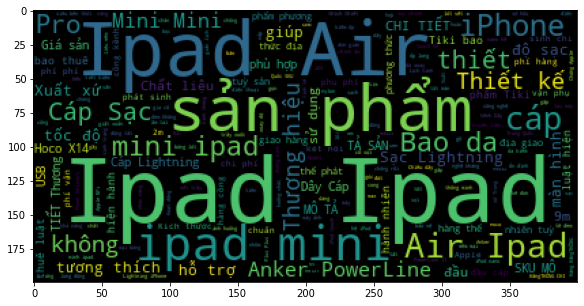

In [ ]:
plt.figure(figsize=(10,5))
wc = WordCloud(stopwords=stop_words).generate(wordcloud_text)
plt.imshow(wc)

## Lưu kết quả của của model đã build

In [ ]:
info = []
for product_id, v in results.items():
  for item in v:
    info.append({
        'product_id': product_id,
        'recomment_product_id': item[1],
        'score': item[0]
    })
content_based_df = pd.DataFrame(info)

In [ ]:
content_based_df.head(5)

,product_id,recomment_product_id,score
0,48102821,56365197,0.540924
1,48102821,22413470,0.540525
2,48102821,50319688,0.511611
3,48102821,48273751,0.499176
4,48102821,70772235,0.485100


In [ ]:
content_based_df.to_csv('/content/gdrive/MyDrive/LDS0_k271_NgoThiNga/Project 3/dataset/Model_Result/Content_based_RS.csv')